<a href="https://colab.research.google.com/github/tsakailab/prml/blob/master/ipynb/ex_MNIST_LDAembedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LDAによる低次元化（dimensionality reduction by linear discriminant analysis）

MNIST画像集合を線形判別分析（LDA）
で識別的な低次元空間に埋め込み，観察します．

2クラスの場合は，決定境界の法線ベクトル $\boldsymbol{w}$ が最もクラスの違いが表れる識別的な特徴の座標軸（1次元）です．

クラス数 $C>2$ の多クラス線形判別分析（multiclass LDA）では，各クラスの特徴が正規分布し，分散共分散が等しいと仮定します．識別的な低次元空間への埋め込みとは，クラス間の散らばりが大きく，クラス内の散らばりが小さく見えるような座標軸だけでデータを近似的に表すことです．そのような座標軸は一般化固有ベクトル（generalized eigenvectors）として計算できます（付録参照）．

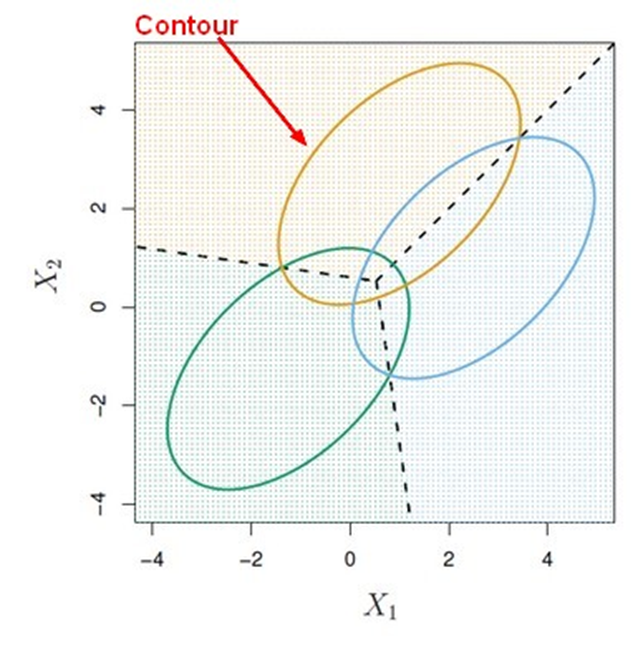


参考資料：
- [Linear discriminant analysis@Wikipedia](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)
- [Linear and Quadratic Discriminant Analysis@scikit-learn](https://scikit-learn.org/stable/modules/lda_qda.html)
- [Linear Discriminant Analysis – Bit by Bit](https://sebastianraschka.com/Articles/2014_python_lda.html)
- [Statistics - Fisher (Multiple Linear Discriminant Analysis | multi-variant Gaussian)
](https://datacadamia.com/data_mining/linear_discriminant_analysis_multiple)

----

氏名：

学生番号：

----
## 基本課題（必須）

    1. 手書き数字画像MNISTの 1，4，7，9 の4クラスを線形判別分析で低次元化したとき，
       第1成分（comp. 1）はこれらのクラスをどのように分類するために役立つ特徴量ですか．
       同様に，第2成分（comp. 2）と第3成分（comp. 3）は，それぞれどのクラスについて識別的な特徴量であると言えますか．理由と共に回答してください．

（ここに回答を書いてください）



    2. Fashion-MNISTについて，線形判別分析でどのクラスが他のクラスと識別し易い・し難いですか．低次元空間における分布と混同行列に基づき調べてください．
       また，識別し易い・し難い原因についても考察してください．

（ここに回答を書いてください）



    3. 上記の参考資料等をもとに，線形判別分析による低次元化の原理について調査し，理解できた範囲で解説してください．

（ここに回答を書いてください）



----
発展課題（任意）がこのノートブックの後半にあります．

### データ集合を取得します．

In [ ]:
from torchvision import datasets

# [MNIST](http://yann.lecun.com/exdb/mnist/)
tvds = datasets.MNIST('./data', download=True, train=True)

# [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)
#tvds = datasets.FashionMNIST('./data', download=True, train=True)

# [Kuzushiji-MNIST](https://github.com/rois-codh/kmnist)
#tvds = datasets.KMNIST('./data', download=True, train=True)

Ximages_all, y_all = tvds.data.numpy(), tvds.targets.numpy()

# [EMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.EMNIST.html)
#tvds = datasets.EMNIST('./data', download=True, train=True, split='letters')
#Ximages_all, y_all = tvds.data.transpose_(-1,-2).numpy(), tvds.targets.numpy() - 1

In [ ]:
#@title ☆画像数とサイズを確認します（画像を加工したい場合はこのセルを編集して利用してください）．
import numpy as np
from skimage.filters import gaussian
from skimage.exposure import equalize_hist as eh
from skimage.transform import resize

Ximages = Ximages_all.copy()
y = y_all.copy()

'''
* blurring (https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.gaussian)
* histogram equalization (https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html)
* resize images (https://scikit-image.org/docs/stable/auto_examples/transform/plot_rescale.html)
'''
#Ximages = gaussian(np.float32(Ximages_all.transpose((1,2,0))), sigma=1.0, multichannel=True).transpose(2,0,1)
#Ximages = eh(Ximages_all.transpose((1,2,0))).transpose(2,0,1) * 255
#height, width = 8, 8; Ximages = resize(np.float32(Ximages_all.transpose((1,2,0))), (height, width)).transpose(2,0,1)

''' simulate noisy images '''
#Ximages = Ximages + np.random.rand(*Ximages.shape) * 200; Ximages = np.clip(Ximages,a_min=0,a_max=255)

Ximages = np.uint8(Ximages)
print("(#images, height, width)", Ximages.shape)
print(Ximages.dtype, ", max. pixel value = ", Ximages.max())

MNIST class labels

| [MNIST](http://yann.lecun.com/exdb/mnist/) | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
| - | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) | **T-shirt/top** | Trouser | **Pullover** | Dress | **Coat** | Sandal |  **Shirt** | Sneaker | Bag | Ankle boot |
| [Kuzushiji-MNIST](https://github.com/rois-codh/kmnist) | お | き | す | つ | な | は |  ま | や | れ | を |

In [ ]:
#@title 画像を表示する関数 implot を定義し，画像を例示します．
%matplotlib inline
!wget -q -N https://gist.githubusercontent.com/tsakai-g/c54a8fa059f9c655290586ec1cc2ec7b/raw/implot.py
%run implot.py

print("%d images in total" % len(y))
p = np.random.permutation(len(y))
implot(Ximages[p], y[p], num=16, vmin=0, vmax=255)

### 4クラスの識別問題にしたい場合（さもなくば実行しなくてよいです）
- このセルの `c0` ～ `c3` でクラスを指定して実行してください．
- 全クラスを使う場合に戻したいときは「☆画像数とサイズを確認します」のセルから実行し直してください．

In [ ]:
c0 = 1 # choose from 0 to 9
c1 = 4 # choose from 0 to 9
c2 = 7 # choose from 0 to 9
c3 = 9 # choose from 0 to 9

Ximages = Ximages[np.logical_or.reduce((y == c0, y == c1, y == c2, y == c3))]
y = y[np.logical_or.reduce((y == c0, y == c1, y == c2, y == c3))]

p = np.random.permutation(len(y))
implot(Ximages[p], y[p], num=20)

### ☆訓練データと検証データに分けます．
- 画像を `Ximages_train` と `Ximages_val` に分けます．それぞれ `n_train` 枚と `n_val` 枚の画像です．
- `Ximages_train` と `Ximages_val` を，それぞれ shape が `(n_train, 画素数)`，`(n_val，画素数)` の NumPy 配列にしたものが `X_train`，`X_val` です．

In [ ]:
from sklearn.model_selection import train_test_split

# split the data into training and validation sets
Ximages_train, Ximages_val, y_train, y_val = train_test_split(Ximages, y, train_size=0.8)

n_train = len(Ximages_train)
n_val = len(Ximages_val)

# reshape to 28*28=784-dimensional feature vectors
X_train = np.reshape(Ximages_train, (Ximages_train.shape[0], -1)) / 255   # (n_train, 784)
X_val = np.reshape(Ximages_val, (Ximages_val.shape[0], -1)) / 255         # (n_val, 784)
print("X_train.shape = ", X_train.shape)
print("X_val.shape = ", X_val.shape)

### ★線形判別分析を実行します（**2次元化の場合**）．
- [sklearn.discriminant_analysis.LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)を使用します．引数の仕様とデフォルトの値を確認してください．

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis(n_components=2)

Xe_train = model.fit_transform(X_train, y_train)
Xe_val = model.transform(X_val)

In [ ]:
#@title 2次元データ X を y で色分けして正方形内にプロットする関数 plot_embedding2d(X, y) を定義します．
# https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#helper-function-to-plot-embedding
%matplotlib inline
!wget -q -N https://gist.githubusercontent.com/tsakai-g/a0730f3692dd915a19a8e7598806e1fe/raw/plot_embedding2d.py
%run plot_embedding2d.py

In [ ]:
# 全部表示すると多いので，ランダムに n 個だけ表示する．
nt = min(100, n_train)
pt = np.random.choice(X_train.shape[0], nt, replace=False)

nv = min(100, n_val)
pv = np.random.choice(X_val.shape[0], nv, replace=False)

sc = plot_embedding2d(Xe_train[pt], y_train[pt], title="train", xlabel="comp. 1", ylabel="comp. 2")
plot_embedding2d(Xe_val[pv], y_val[pv], Scaler=sc, title="val", xlabel="comp. 1", ylabel="comp. 2")

import matplotlib.pyplot as plt
plt.show()

### ★線形判別分析を実行します（**3次元化の場合**）．
- [sklearn.discriminant_analysis.LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)を使用します．引数の仕様とデフォルトの値を確認してください．

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis(n_components=3)

Xe_train = model.fit_transform(X_train, y_train)
Xe_val = model.transform(X_val)

In [ ]:
#@title 3次元データ X を y で色分けして立方体内にプロットする関数 plot_embedding3d(X, y) を定義します．
%matplotlib inline
!wget -q -N https://gist.githubusercontent.com/tsakai-g/a0730f3692dd915a19a8e7598806e1fe/raw/plot_embedding3d.py
%run plot_embedding3d.py

In [ ]:
# 全部表示すると多いので，ランダムに n 個だけ表示する．
nt = min(300, n_train)
pt = np.random.choice(X_train.shape[0], nt, replace=False)
sc = plot_embedding3d(Xe_train[pt], y_train[pt])

nv = min(300, n_val)
pv = np.random.choice(X_val.shape[0], nv, replace=False)
plot_embedding3d(Xe_val[pv], y_val[pv], Scaler=sc)

In [ ]:
#@title 識別の結果を例示します（上：訓練データ，下：検証データ）．
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_train)
print("Accuracy on training data: ", accuracy_score(y_train, y_pred))
p = np.random.permutation(n_train)
plotMNIST(Ximages_train[p], y_train[p], y_pred[p], num=16)
plt.show()

y_pred = model.predict(X_val)
print("\nAccuracy on validation data: ", accuracy_score(y_val, y_pred))
p = np.random.permutation(n_val)
plotMNIST(Ximages_val[p], y_val[p], y_pred[p], num=16)

MNIST class labels

| [MNIST](http://yann.lecun.com/exdb/mnist/) | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
| - | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) | T-shirt/top | Trouser | Pullover | Dress | Coat | Sandal |  Shirt | Sneaker | Bag | Ankle boot |
| [Kuzushiji-MNIST](https://github.com/rois-codh/kmnist) | お | き | す | つ | な | は |  ま | や | れ | を |

In [ ]:
#@title 混同行列（行：正解，列：予測）
from sklearn import metrics
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

cm = metrics.confusion_matrix(y_val, y_pred)
print(cm)

print(cm.sum(axis=0))

In [ ]:
#@title おまけ
import seaborn as sns

# Make predictions on test data
cm = metrics.confusion_matrix(y_val, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(9,9))
sns.heatmap(cm_normalized, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

--------
## 発展課題（任意）

学習済みの畳み込みニューラルネット（DCNN）で画像から抽出した特徴（DCNN特徴）を用いて線形判別分析してみましょう．
画素値のまま線形判別分析に用いるよりも，識別し易くなるクラスがあるかもしれません．

    1. Fashion-MNISTの 0:T-shirt/top, 2:Pullover, 4:Coat, 6:Shirt の4クラスについて，画素値を用いた場合と，DCNN特徴を用いた場合を比較してください．
       識別的な低次元化がし易いのはどちらでしょうか．また，識別の結果はどうですか．

（ここに回答を書いてください）



    2. MedMNISTについても，同様に比較・考察しましょう．

（ここに回答を書いてください）[参考文献](https://arxiv.org/abs/2110.14795)





In [ ]:
#@title 学習済みの畳み込みニューラルネットワークで特徴抽出する関数 feature_extractor を定義します．<p><ul><li>「☆訓練データと検証データに分けます．」のセルを実行後に，下のセルで `X_train` と `X_val` を `feature_extractor` で作成してください．</li><li>`X_train` と `X_val` を作成後，「★線形判別分析を実行します」に戻って，線形判別分析による低次元化を実行してください．</li></ul>
import torch
from torchvision import models

#model_pretrained = models.alexnet(weights='DEFAULT', progress=False)
#model_pretrained = models.vgg16(weights='DEFAULT')
#model_pretrained = models.vgg16_bn(weights='DEFAULT')

#model_pretrained = models.resnet50(weights='DEFAULT')
#model_pretrained = models.googlenet(weights='DEFAULT')
#model_pretrained = models.mobilenet_v3_small(weights='DEFAULT')
model_pretrained = models.efficientnet_b0(weights='DEFAULT')

#feature_extractor = model_pretrained.features

class DCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.features = model_pretrained.features
        self.gap = torch.nn.AdaptiveAvgPool2d(output_size=(1,1))

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x).squeeze(-1).squeeze(-1) # [B, C, H=1, W=1] -> [B, C]
        return x

DCNNfeatures = DCNN()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
DCNNfeatures.eval().to(device)

import torchvision.transforms as transforms

def feature_extractor(Ximages, batch_size=256): # Ximages(n_samples, height, width)
    with torch.no_grad():
        imgs = torch.tensor(Ximages).to(device)
        if Ximages.ndim == 3:
            imgs.unsqueeze_(1)
            imgs = imgs / 255.0
            n, _, h, w = imgs.shape
            imgs = imgs.view(n, 1, h, w).expand(-1,3,-1,-1)
        else:
            imgs = imgs.permute(0,3,1,2)
            imgs = transforms.Normalize(mean = [0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(imgs.float())

        dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)
        f = []
        for bimgs in dataloader:
            bimgs = transforms.Resize(112)(bimgs)
            x = DCNNfeatures(bimgs.to(device))
            f.append(x.cpu().numpy())

    return np.concatenate(f)

In [ ]:
# 特徴抽出
# 注意：数分かかります！ ランタイムのタイプをGPUへ変更することを推奨します．CPUでは，colabのメモリ不足でカーネルがクラッシュすることがあります．
X_train = feature_extractor(Ximages_train)
X_val = feature_extractor(Ximages_val)

In [ ]:
#@title [MedMNIST](https://github.com/MedMNIST/MedMNIST)を使う場合<p>以下を実行後，このJupyter Notebook前半の「☆画像数とサイズを確認します（画像を加工したい場合はこのセルを編集して利用してください）．」以降を実行できます．
!pip install -q medmnist
import medmnist
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

In [ ]:
# 'pneumoniamnist', 'chestmnist', 'octmnist', 'breastmnist', 'tissuemnist', 'organamnist', 'organcmnist', 'organsmnist'
data_flag = 'retinamnist' # 'octmnist'
DataClass = getattr(medmnist, medmnist.INFO[data_flag]['python_class'])

tvds = DataClass(split='train', download=True)
#tvds = DataClass(split='test', download=True)

print(tvds)
Ximages_all, y_all = tvds.imgs, tvds.labels.ravel()

お疲れさまでした．

## 付録：多クラス線形判別分析の計算

クラス間の散らばり $B$ が大きく，クラス内の散らばり $W$ が小さく見える座標軸の向き $\boldsymbol{w}$ を見つけましょう．
クラス間の散らばりを表す行列 $\boldsymbol{S}_\mathrm{b}$，クラス内のデータの散らばりを表す行列 $\boldsymbol{S}_\mathrm{w}$ が与えられれば，$B=\boldsymbol{w}^\top\boldsymbol{S}_\mathrm{b}\boldsymbol{w}$，$W=\boldsymbol{w}^\top\boldsymbol{S}_\mathrm{w}\boldsymbol{w}$ のように測れます．これらの比
$$R(\boldsymbol{w})=\frac{\boldsymbol{w}^\top\boldsymbol{S}_\mathrm{b}\boldsymbol{w}}{\boldsymbol{w}^\top\boldsymbol{S}_\mathrm{w}\boldsymbol{w}}$$
は，[一般化レイリー商（generalized Rayleigh quotient）](https://en.wikipedia.org/wiki/Rayleigh_quotient)と呼ばれます．$R(\boldsymbol{w})$ を最大にするベクトル $\boldsymbol{w}$ を求める問題は，$\nabla_\boldsymbol{w}R(\boldsymbol{w})=\boldsymbol{0}$ から，$\boldsymbol{S}_\mathrm{w}$ に対する $\boldsymbol{S}_\mathrm{b}$ の[一般化固有値問題](https://arxiv.org/abs/1903.11240)
$$\boldsymbol{S}_\mathrm{b}\boldsymbol{w}=\lambda\boldsymbol{S}_\mathrm{w}\boldsymbol{w}$$
に帰着します．
[一般化固有値と一般化固有ベクトルは $R(\boldsymbol{w})$ の極値と停留点です](https://math.stackexchange.com/questions/1661784/differentiating-rayleigh-quotient)．

<br>

$\boldsymbol{S}_\mathrm{w}$ が正則ならば，一般化固有ベクトルは $\boldsymbol{S}_\mathrm{w}^{-1}\boldsymbol{S}_\mathrm{b}$ の固有ベクトルと同じです．$\boldsymbol{S}_\mathrm{b}$ と $\boldsymbol{S}_\mathrm{w}$ は対称行列なので，
$\boldsymbol{S}_\mathrm{w}^{-1}$ も $\boldsymbol{S}_\mathrm{w}^{-1}\boldsymbol{S}_\mathrm{b}$ も対称行列です．対称行列の固有ベクトルは互いに直交します．つまり，$R(\boldsymbol{w})$ の極大値を与える $\boldsymbol{w}$ を上位から選ぶことで，上位の固有値に対する固有ベクトルから直交座標系を作れます．クラス間の散らばりが大きく，クラス内の散らばりが小さく見える低次元空間の直交座標系です．

<br>

クラス間の散らばりを表す行列 $\boldsymbol{S}_\mathrm{b}$，クラス内のデータの散らばりを表す行列 $\boldsymbol{S}_\mathrm{w}$ は，下記のように求められます．

- 各クラスのデータ集合を $\mathcal{D}_1,\dots,\mathcal{D}_C$ とし，第 $i$ クラスのデータ数を $|\mathcal{D}_i|$ と表します．
- 全データの標本平均を $\hat{\boldsymbol{\mu}}$ とします：
$\displaystyle\hat{\boldsymbol{\mu}}=\frac{1}{\sum_{i=1}^C|\mathcal{D}_i|}\sum_{i=1}^C\sum_{\boldsymbol{x}\in\mathcal{D}_i}\boldsymbol{x}$
- 各クラスの標本平均を $\hat{\boldsymbol{\mu}}_1,\dots,\hat{\boldsymbol{\mu}}_C$ とします：$\displaystyle\hat{\boldsymbol{\mu}}_i=\frac{1}{|\mathcal{D}_i|}\sum_{\boldsymbol{x}\in\mathcal{D}_i}\boldsymbol{x}$

- クラス間の散らばりを表す行列（between-class scatter matrix）：
$$\boldsymbol{S}_\mathrm{b}=\sum_{i=1}^C n_i(\hat{\boldsymbol{\mu}}_i-\hat{\boldsymbol{\mu}})(\hat{\boldsymbol{\mu}}_i-\hat{\boldsymbol{\mu}})^\top$$

- クラス内のデータの散らばりを表す行列（within-class scatter matrix） $\boldsymbol{S}_\mathrm{w}$ は，各クラスの標本分散共分散行列 $\hat{\boldsymbol{\Sigma}}_i$（最尤推定）の重み付き和として見積もれます：
$$\boldsymbol{S}_\mathrm{w}=\sum_{i=1}^C\sum_{\boldsymbol{x}\in\mathcal{D}_i}(\boldsymbol{x}-\hat{\boldsymbol{\mu}}_i)(\boldsymbol{x}-\hat{\boldsymbol{\mu}}_i)^\top=\sum_{i=1}^C|\mathcal{D}_i|\hat{\boldsymbol{\Sigma}_i}$$


なお，[sklearn.discriminant_analysis.LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)は，$\boldsymbol{S}_\mathrm{b}$ を上記の式で計算せず，[$\boldsymbol{S}_\mathrm{b}=\boldsymbol{S}_\mathrm{t}-\boldsymbol{S}_\mathrm{w}$](https://github.com/scikit-learn/scikit-learn/blob/7f9bad99d6e0a3e8ddf92a7e5561245224dab102/sklearn/discriminant_analysis.py#L465) のように計算しています．ここで，$\boldsymbol{S}_\mathrm{t}$ は，次式で計算できる全データの散らばりを表す行列です．
$$\boldsymbol{S}_\mathrm{t}=\sum_{i=1}^C\sum_{\boldsymbol{x}\in\mathcal{D}_i}(\boldsymbol{x}-\hat{\boldsymbol{\mu}})(\boldsymbol{x}-\hat{\boldsymbol{\mu}})^\top$$
$\boldsymbol{S}_\mathrm{t}=\boldsymbol{S}_\mathrm{b}+\boldsymbol{S}_\mathrm{w}$
の成立を[確認してください](https://stats.stackexchange.com/questions/123490/what-is-the-correct-formula-for-between-class-scatter-matrix-in-lda)．